# Task 2. Recursive matrix multiplication

Implement both naive and **[Strassen](https://en.wikipedia.org/wiki/Strassen_algorithm) matrix multiplication**. You can consider only cases, where matrix is square and size is $2^N$. **Avoid using numpy library functions and operators {\*, @, +, -}. Implement you own `plus` and `minus` functions**


## Strassen multiplication
This method is based on a rule, that matrices can be multiplied block-wise.

$${\mathbf  {A}}={\begin{bmatrix}{\mathbf  {A}}_{{1,1}}&{\mathbf  {A}}_{{1,2}}\\{\mathbf  {A}}_{{2,1}}&{\mathbf  {A}}_{{2,2}}\end{bmatrix}}{\mbox{ , }}{\mathbf  {B}}={\begin{bmatrix}{\mathbf  {B}}_{{1,1}}&{\mathbf  {B}}_{{1,2}}\\{\mathbf  {B}}_{{2,1}}&{\mathbf  {B}}_{{2,2}}\end{bmatrix}}{\mbox{ , }}{\mathbf  {C}}={\begin{bmatrix}{\mathbf  {C}}_{{1,1}}&{\mathbf  {C}}_{{1,2}}\\{\mathbf  {C}}_{{2,1}}&{\mathbf  {C}}_{{2,2}}\end{bmatrix}}$$

$${\mathbf  {C}}_{{1,1}}={\mathbf  {A}}_{{1,1}}{\mathbf  {B}}_{{1,1}}+{\mathbf  {A}}_{{1,2}}{\mathbf  {B}}_{{2,1}}$$

$${\mathbf  {C}}_{{1,2}}={\mathbf  {A}}_{{1,1}}{\mathbf  {B}}_{{1,2}}+{\mathbf  {A}}_{{1,2}}{\mathbf  {B}}_{{2,2}}$$

$${\mathbf  {C}}_{{2,1}}={\mathbf  {A}}_{{2,1}}{\mathbf  {B}}_{{1,1}}+{\mathbf  {A}}_{{2,2}}{\mathbf  {B}}_{{2,1}}$$

$${\mathbf  {C}}_{{2,2}}={\mathbf  {A}}_{{2,1}}{\mathbf  {B}}_{{1,2}}+{\mathbf  {A}}_{{2,2}}{\mathbf  {B}}_{{2,2}}$$

Follow the [explanation on Wikipedia](https://en.wikipedia.org/wiki/Strassen_algorithm#Algorithm), compute $M_1-M_7$ and use them to find $C$.

In [1]:
import numpy as np

class MyMatrix:
    '''
    This class wraps initial matrix and uses offsets to define desired location of data
    '''
    def __init__(self, matrix, offset=(0, 0), shape=None):
        self.matrix = matrix
        self.offset = offset
        self.shape = shape or matrix.shape

    def get(self, i, j):
        return self.matrix[i + self.offset[0], j + self.offset[1]]
        
    def set(self, i, j, value):
        self.matrix[i + self.offset[0], j + self.offset[1]] = value
        
    def detach(self):
        return self.matrix[self.offset[0]:self.offset[0] + self.shape[0], 
                           self.offset[1]:self.offset[1] + self.shape[1]]

    def patch(self, ptch):
        self.matrix[self.offset[0]:self.offset[0] + self.shape[0], 
                    self.offset[1]:self.offset[1] + self.shape[1]] = ptch
        
    def split(self):
        h1 = self.shape[0] // 2
        h2 = self.shape[0] - h1
        w1 = self.shape[1] // 2
        w2 = self.shape[1] - w1
        A11 = MyMatrix(self.matrix, self.offset, (h1, w1))
        A12 = MyMatrix(self.matrix, (self.offset[0], self.offset[1] + w1), (h1, w2))
        A21 = MyMatrix(self.matrix, (self.offset[0] + h1, self.offset[1]), (h2, w1))
        A22 = MyMatrix(self.matrix, (self.offset[0] + h1, self.offset[1] + w1), (h2, w2))
        return [[A11, A12], [A21, A22]]
        
def plus(A, B, dest):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            dest.set(i, j, A.get(i, j) + B.get(i, j))
    return dest

def minus(A, B, dest):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            dest.set(i, j, A.get(i, j) - B.get(i, j))
    return dest

def naive_mult(A, B):
    C = np.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                C[i, j] += A[i, k] * B[k, j] 
    return C

def strassen_mult(A, B, dest):
    # stop rule:
    if A.shape == (1, 1):
        dest.set(0, 0, A.get(0, 0) * B.get(0, 0))
        return dest
    
    A_ = A.split()
    B_ = B.split()
    C_ = dest.split()

    # this memory can be also allocated one time, but I am too lazy to do this
    Mm = [MyMatrix(np.zeros(A_[0][0].shape)) for i in range(9)]
    TMP1, TMP2 = Mm[0], Mm[8]
    strassen_mult(
        plus(A_[0][0], A_[1][1], TMP1),
        plus(B_[0][0], B_[1][1], TMP2),
        Mm[1])

    strassen_mult(
        plus(A_[1][0], A_[1][1], TMP1),
        B_[0][0],
        Mm[2])

    strassen_mult(
        A_[0][0],
        minus(B_[0][1], B_[1][1], TMP1),
        Mm[3])
    
    strassen_mult(
        A_[1][1],
        minus(B_[1][0], B_[0][0], TMP1),
        Mm[4])
    
    strassen_mult(
        plus(A_[0][0], A_[0][1], TMP1),
        B_[1][1],
        Mm[5])    
    
    strassen_mult(
        minus(A_[1][0], A_[0][0], TMP1),
        plus(B_[0][0], B_[0][1], TMP2),
        Mm[6])  

    strassen_mult(
        minus(A_[0][1], A_[1][1], TMP1),
        plus(B_[1][0], B_[1][1], TMP2),
        Mm[7]) 
    
    # c11
    plus(
        minus(
            plus(Mm[1], Mm[4], TMP1),
            Mm[5],
            TMP2
        ),
        Mm[7],
        C_[0][0]
    )
    
    #c12
    plus(Mm[3], Mm[5], C_[0][1])
    
    #c21
    plus(Mm[2], Mm[4], C_[1][0])
    
    #c22
    plus(
        plus(
            minus(Mm[1], Mm[2], TMP1),
            Mm[3],
            TMP2
        ),
        Mm[6],
        C_[1][1]
    )
    return dest


O = np.random.rand(1, 1)
A = np.random.rand(64, 64)
B = np.random.rand(64, 64)
AB = np.zeros(A.shape)
C = np.random.rand(128, 128)
D = np.random.rand(128, 128)
CD = np.zeros(C.shape)

assert np.allclose(A @ B, naive_mult(A, B))
assert np.allclose(A @ B, strassen_mult(MyMatrix(A), MyMatrix(B), MyMatrix(AB)).matrix)
assert np.allclose(C @ D, naive_mult(C, D))
assert np.allclose(C @ D, strassen_mult(MyMatrix(C), MyMatrix(D), MyMatrix(CD)).matrix)

In [2]:
A =  MyMatrix(np.eye(4))
B = MyMatrix(np.eye(4))
C = MyMatrix(np.zeros(A.shape))
strassen_mult(A, B, C)
print(C.matrix)
assert np.allclose(A.matrix @ B.matrix, C.matrix)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


### Run an experiment and show, where Strassen algorithm is becoming faster then naive in absolute time measurements.

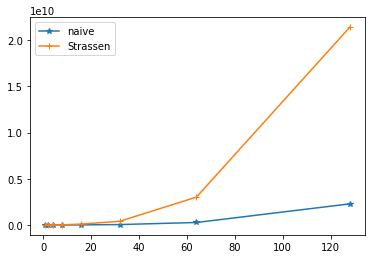

In [4]:
import matplotlib.pyplot as plt
import time

sizes = [2 ** i for i in range(8)]
naive_times = []
strassen_times = []

for size in sizes:
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)
    
    s = time.perf_counter_ns()
    C = naive_mult(A, B)
    f = time.perf_counter_ns()
    naive_times.append(f - s)

    s = time.perf_counter_ns()
    C = strassen_mult(MyMatrix(A), MyMatrix(B), MyMatrix(C)).matrix
    f = time.perf_counter_ns()

    strassen_times.append(f - s)
    
plt.plot(sizes, naive_times, marker="*", label="naive")
plt.plot(sizes, strassen_times, marker="+", label="Strassen")
plt.legend()
plt.show()

### Combine Strassen and naive approaches for the faster algorithm

In [5]:
def strassen_improved(A, B, dest):
    # THIS IS THE ONLY IMPROVEMENT: run naive if matrix is small
    if A.shape[0] < 100:
        dest.patch(naive_mult(A.detach(), B.detach()))
        return dest
    
    A_ = A.split()
    B_ = B.split()
    C_ = dest.split()

    # this memory can be also allocated one time, but I am too lazy to to this
    Mm = [MyMatrix(np.zeros(A_[0][0].shape)) for i in range(9)]
    TMP1, TMP2 = Mm[0], Mm[8]
    strassen_improved(
        plus(A_[0][0], A_[1][1], TMP1),
        plus(B_[0][0], B_[1][1], TMP2),
        Mm[1])

    strassen_improved(
        plus(A_[1][0], A_[1][1], TMP1),
        B_[0][0],
        Mm[2])

    strassen_improved(
        A_[0][0],
        minus(B_[0][1], B_[1][1], TMP1),
        Mm[3])
    
    strassen_improved(
        A_[1][1],
        minus(B_[1][0], B_[0][0], TMP1),
        Mm[4])
    
    strassen_improved(
        plus(A_[0][0], A_[0][1], TMP1),
        B_[1][1],
        Mm[5])    
    
    strassen_improved(
        minus(A_[1][0], A_[0][0], TMP1),
        plus(B_[0][0], B_[0][1], TMP2),
        Mm[6])  

    strassen_improved(
        minus(A_[0][1], A_[1][1], TMP1),
        plus(B_[1][0], B_[1][1], TMP2),
        Mm[7]) 
    
    # c11
    plus(
        minus(
            plus(Mm[1], Mm[4], TMP1),
            Mm[5],
            TMP2
        ),
        Mm[7],
        C_[0][0]
    )
    
    #c12
    plus(Mm[3], Mm[5], C_[0][1])
    
    #c21
    plus(Mm[2], Mm[4], C_[1][0])
    
    #c22
    plus(
        plus(
            minus(Mm[1], Mm[2], TMP1),
            Mm[3],
            TMP2
        ),
        Mm[6],
        C_[1][1]
    )
    return dest

O = np.random.rand(1, 1)
A = np.random.rand(64, 64)
B = np.random.rand(64, 64)
AB = np.zeros(A.shape)
C = np.random.rand(128, 128)
D = np.random.rand(128, 128)
CD = np.zeros(C.shape)

assert np.allclose(A @ B, strassen_improved(MyMatrix(A), MyMatrix(B), MyMatrix(AB)).matrix)
assert np.allclose(C @ D, strassen_improved(MyMatrix(C), MyMatrix(D), MyMatrix(CD)).matrix)

### Plot the graph for an improved function

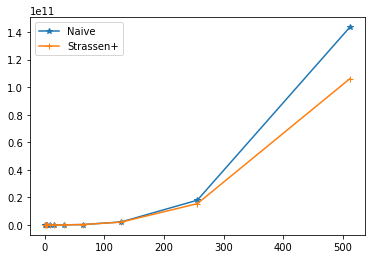

In [9]:
import matplotlib.pyplot as plt

sizes = [2 ** i for i in range(10)]
strassen_times = []
naive_times = []

for size in sizes:
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)
    
    s = time.perf_counter_ns()
    C = naive_mult(A, B)
    f = time.perf_counter_ns()
    naive_times.append(f - s)
   
    s = time.perf_counter_ns()
    C = strassen_improved(MyMatrix(A), MyMatrix(B), MyMatrix(C)).matrix
    f = time.perf_counter_ns()

    strassen_times.append(f - s)    

plt.plot(sizes, naive_times, marker="*", label="Naive")
plt.plot(sizes, strassen_times, marker="+", label="Strassen+")
plt.legend()
plt.show()